# Pytorch Workflow

time to explore an example pytorch end to end workflow.

In [20]:
import torch
from torch import nn #  nn contains all of PyTorch's building block for neural networks
import matplotlib.pyplot as plt
device = torch.device("cuda" if (torch.cuda.is_available()==True) else "cpu")

## Data loading and prep
Data can be almost anything in ml lmfao.

* Excel spreadsheet
* images
* video
* Audio
* Text
* dna
* etc

ML has 2 main parts:
1. Get data inot numerical representation.
2. Buildig a model to learn patterns in that numerical representation.

To show case this lets create some known data using the linear regresion formula.

We'll use a linear regression formula to make a straight line with *known* parameters.

In [21]:
# Creating known parameters

weight = 0.7
bias = 0.3

start =0
end = 1
step = 0.02

X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X +bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

In [22]:
### Splitting datasets into test and train
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split],y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [23]:
def plot_preds(train_data = X_train,
               train_labels=y_train,
               test_data = X_test,
               test_labels = y_test,
               predictions = None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(train_data, train_labels, c="b", label= "Training data")
    plt.scatter(test_data, test_labels, c="r", label= "Testing data")
    
    if predictions is not None:
        plt.scatter(test_data,predictions,c= "g",label= "Predictions")

    plt.legend(prop = {"size": 14})

    plt.show()

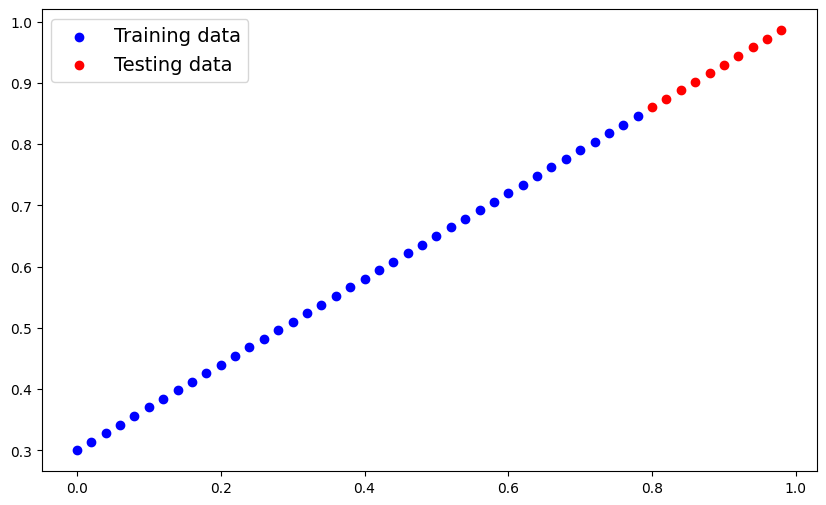

In [24]:
plot_preds()

# 2. Build model
our first PyTorch model!

What the model does:
* Start with random values(weight & bias)
* Look at training data and adjust the random values to better represent the ideal values

How does it do so?

throught 2 main algos:
1. Gradient Descent
2. Backpropogation

In [25]:
# Create linea regression model class

class LinearRegressionModel(nn.Module): #<- almost everything in PyTorch inherits from nn.module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype = torch.float))
        
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor: #  <- "x" is the input data
        return self.weights * x + self.bias 
    

### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs(a neural network is considered as computational graph)

* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch model try and learn, often a PyTorch layer from torch.nnwill set it up for us 

* torch.nn.Module - The base class for all neural network modules, if you sublcass it, you should overwrite forward()

* torch.optim - This is where te optimizers in PyTorch live, they will help with gradient descent.

* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in forward computation.computation


### Checking the contents of the pytorch model boi

as we have created the model lets now check the internals of the model
So we can check our model params using .parameters()

In [26]:
# Create a random seed
torch.manual_seed(42)

# Creating a instance of the model
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())


[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [27]:
# List named params
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_model()`

To chekc the model's predictive power, let's see how well it predicts `y_test` based on `X_test`
When we pass data through our model, it's going to run it through the `forward` function

In [28]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

In [29]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

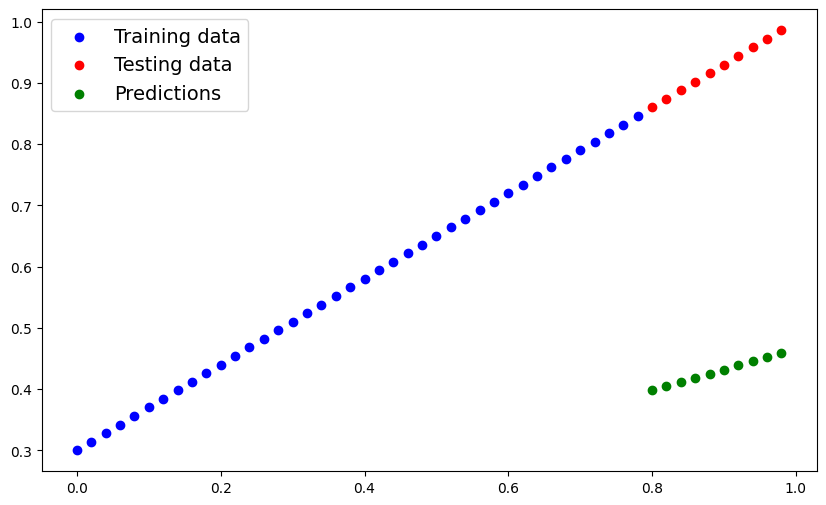

In [30]:
plot_preds(predictions= y_preds)

### 3. Train model

The whole idea of training the model is to make the model go from poor representation of data to a better representation of data

One way to measure how poor or wrong the model is to use a loss function

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it asa loss function.

Things we need for training the model:

* **Loss Function:** A function to measure how wrong the model's predictions are to the ideaal outputs, lower the better
* **Optimizer:** Takes into account the loss f a model and adjust the model's parameters. (e.g. weight and bias) to improve the loss function

and specifically for PyTorch we need:
* A training loop
* A testing loop

In [31]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [32]:
# setup a loss func
loss_fn = nn.L1Loss()

# setup an optimizer  (Sotchastic Grad descebt)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.001) # lr = Learning rate {the most important hyperparameter}

### Building a training loop and testing loop in PyTorch

A couple of things we need in a trainng loop:
0. Loop through the data
1. Forward pass (this involves the data moving through the forward function) - also called forward propogation

2. Calculate the loss(compare forward pass predictions to ground truth labels)

3. Optimizers zero grad

4. Loss Backward - move backwards through the network to calc the gradients of each of the parameters of our model wrt locales

5. Optimizer step - use the optimizerto adjust or model's parameters to try and improve the loss

OrderedDict([('weights', tensor([0.6994])), ('bias', tensor([0.2998]))])


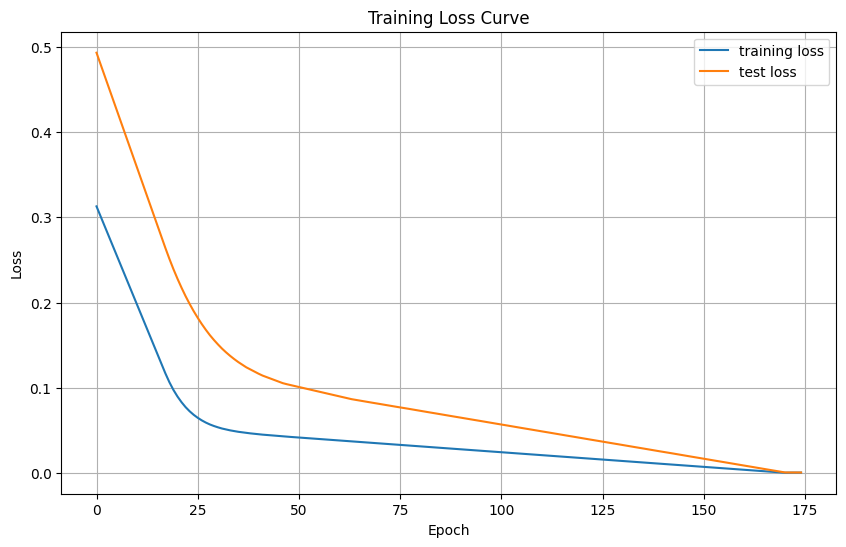

In [33]:
# Epoc is a loop through the data
epochs = 1750
epoch_count = []
lossval = []
test_loss_vals = []
#0. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() # Train mode in PyTorch sets all parameters that require grads to have gradients
    
    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Setup loss function
    loss = loss_fn(y_pred,y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    #4. Perform back propogation on the loss wrt params of the model
    loss.backward()

    #5. Setup the optimizer(updating the model params using the calculated grads) 
    optimizer.step()

    # Testing
    model_0.eval() # Turns out different setting in the model not needed for evaluating
    with torch.inference_mode():
        # 1. forward pass
        test_pred = model_0(X_test)

        #2. Calculate the loss
        test_loss = loss_fn(test_pred,y_test)

        # Printing the process
        if epoch % 10==0:
            lossval.append(loss.item())
            epoch_count.append(epoch)
            test_loss_vals.append(test_loss)

            
print(model_0.state_dict())
plt.figure(figsize=(10, 6))
plt.plot(lossval, label = "training loss")
plt.plot(test_loss_vals, label = "test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()
plt.show()


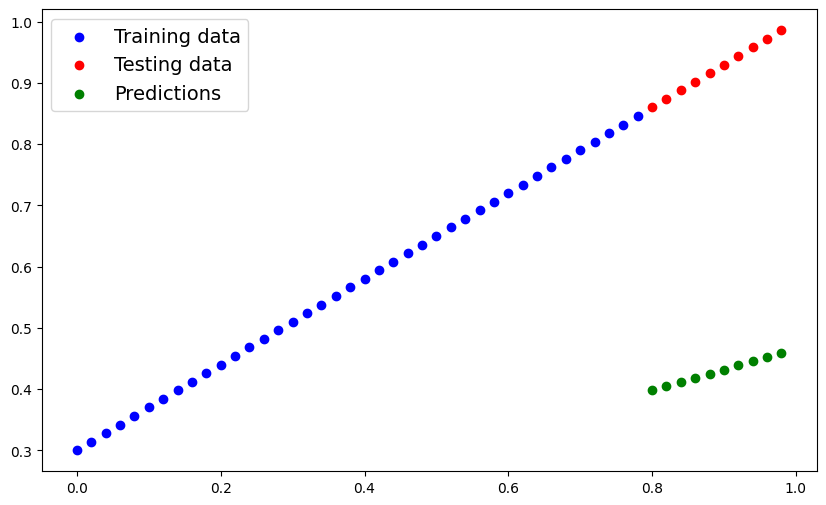

In [34]:
plot_preds(predictions= y_preds)

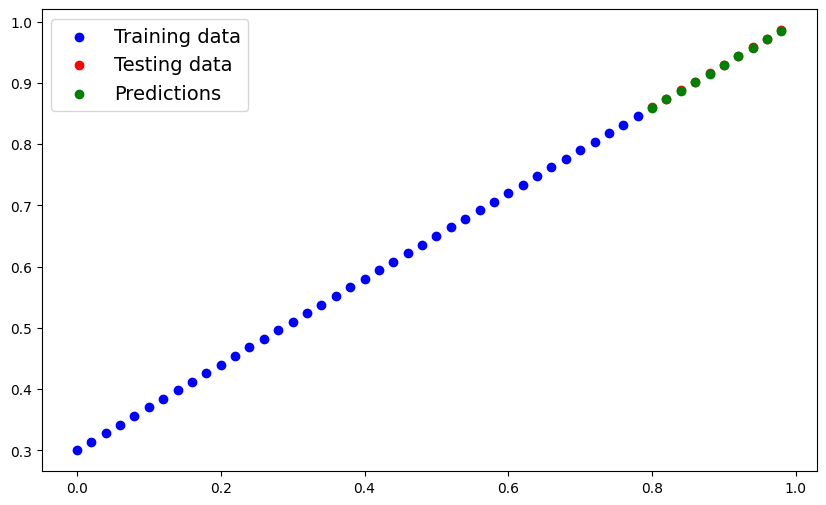

In [35]:
with torch.inference_mode():
    y_pred_new = model_0(X_test)

plot_preds(predictions= y_pred_new)

## Saving a model in Pytorch

There are three main methods you should know for saving and loading models in PyTorch

1. `torch.save()` - allows you save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary

In [36]:
# Save the model's State dict
Model_save_path = "../models/PyTorch_Workflow.pth"
print(f"Saving the model to path:{Model_save_path}")
torch.save(model_0.state_dict(),Model_save_path)

Saving the model to path:../models/PyTorch_Workflow.pth


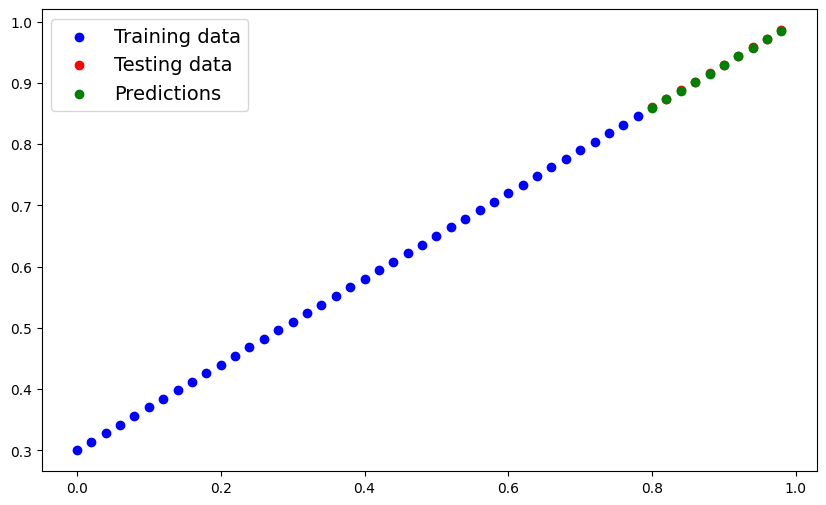

In [37]:
# Loading the saved model

model = LinearRegressionModel()
model.load_state_dict(torch.load(Model_save_path,weights_only=True))
model.eval()

with torch.inference_mode():
    y_load_pred = model(X_test)
plot_preds(predictions= y_load_pred)